In [10]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph", "tidyverse",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial", "ggrepel")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))
n_cores <- detectCores()
cluster <- makeCluster(32)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
source('Rfiles/get_opt_des.R')
clusterExport(cluster, "expo_gen_2stages")

# Optimal Design (minimize E(N))

#### Our method need a given overall sample size N for parameter searching. 
#### So we only discuss the optimal design that minimize the expected sample size.
```math
 \bar{PET} = (PET0\ +\ PET1)\ /\ 2  \\
E_N(n) = \bar{PET} * n + (1\ -\ \bar{PET}) * N
```
#### n is the interim sample size of two groups
#### We would like to find a proper n to min(E(N)) under a given ($\alpha$, power and N)

#### The self-defined function 'get_opt_des' works for this procedure.


## 1. Proportional Hazard
####  <span style="color:yellow">Compare with optimal design of log-rank test in Jung(2017)

In [ ]:
set.seed(2024)
sim_size <- 5000
N <- 112
n <- ceiling( N / 2 )  # total sample size per arm
r <- 60
acc_time <- N / r
cen_time <- 1
lambda_H0 <- 0.9 * 1.5
lambda_H1 <- 0.9
alpha <- 0.05
power <- 0.8

# Log_rank <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#             int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
#             alpha = alpha, power = power, method = 'logrank') 
# Log_rank

sim_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Simple') 
sim_rmst

our_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Complex') 
our_rmst

m1,q1,m2,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
0,0,0,0,0,0,0,0,0,0,NA,NA,NA,NA


,m1,q1,m2,q2,gamma,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2127,-0.03420273,0.3963954,0.02515691,0.7129942,0.06,0.475,0.1058,0.0992,0.8528,0.2904,59.3125,67.6195,63.466,48


-------------
## Minimax & Optimal design (PH)
### Simple and Sculpted RMST

In [8]:
set.seed(2024)
result <- data.frame()
lambda_H1 <- 0.9
HR <- 1.7
lambda_H0 <- lambda_H1 * HR
sim_size <- 5000
r <- 60
cen_time <- 1
alpha <- 0.1
power <- 0.85
result_scu <- c()
result_sim <- c()

for (N in seq(from = 74, to = 76, 2))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    our_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 4, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Complex') 

    res <- our_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- c( 'scu_rmst')
    result_scu <- rbind(result_scu, res)
    saveRDS(result_scu, "tem_result_scu.rds")
}


for (N in seq(from = 88, to = 90, 2))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    sim_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
            alpha = alpha, power = power, method = 'Simple')    

    res <- sim_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- c('sim_rmst')
    result_sim <- rbind(result_sim, res)
    saveRDS(result_sim, "tem_result_sim.rds")
 }
  
result_scu
result_sim


In [7]:
# result_scu <- readRDS("tem_result_scu.rds")
result_scu
result_sim

,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,66,scu_rmst
2,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,68,scu_rmst
2123,0.4376,0.0958,0.0994,0.8504,0.2667,58.6224,67.5092,63.0658,44,70,scu_rmst


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4553,0.3574,0.0766,0.0996,0.8514,0.2170,76.56032,88.69088,82.62560,49,92,sim_rmst
4549,0.3232,0.0624,0.0998,0.8518,0.1928,79.64992,91.22944,85.43968,50,94,sim_rmst
4460,0.4232,0.0784,0.0984,0.8512,0.2508,79.24128,92.89536,86.06832,57,96,sim_rmst
4464,0.4564,0.0904,0.0960,0.8502,0.2734,79.37888,94.31168,86.84528,58,98,sim_rmst


get_opt_des is defined in Rfiles/get_opt_des.R.  
 We repeat this experiment to compare the EN of RMST optimal design with log rank test in table1 under different scenario.   

### <span style="color:yellow"> The optimal designs under Non proportional hazard are shown in  corrsponding ipynb files
---

###  Minimax and Optimal Design for two-stage log-rank test

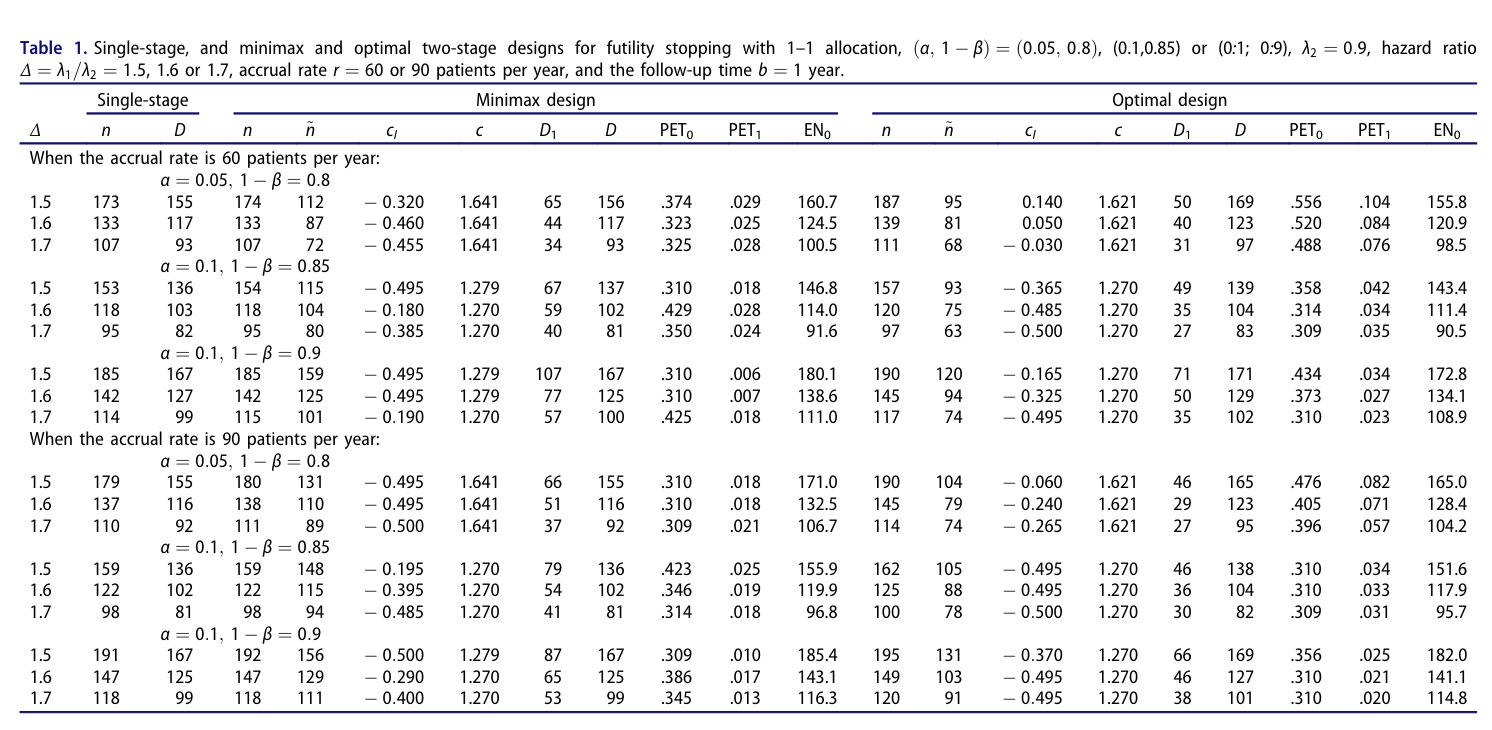

In [7]:
display_jpeg(file='figures/Jung2017_full_table1.jpeg')

In [80]:
set.seed(2024)
sim_size <- 5000
r <- 60
cen_time <- 1
lambda_H0 <- 0.9 * 1.7
lambda_H1 <- 0.9
alpha <- 0.1
power <- 0.85
sel_col <- c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')
result_LR <- data.frame()

for (N in seq(96, 100, by = 2))
{
    n <- ceiling(N / 2) 
    acc_time <- N / r 
    our_lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                int_step = 6, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                alpha = alpha, power = power, method = 'logrank')

    res <- our_lr_opt[, sel_col]
    res$N <- N
    res$Method <- 'log_rank'
    result_LR <- rbind(result_LR, res)
}
result_LR

,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
11638,0.3566,0.0460,0.0998,0.8504,0.2013,84.01824,94.45440,89.23632,63,96,log_rank
12095,0.3822,0.0446,0.0984,0.8504,0.2134,84.69944,96.44792,90.57368,64,98,log_rank
11632,0.3208,0.0514,0.0982,0.8508,0.1861,84.60160,97.53280,91.06720,52,100,log_rank


----
# Real Example of Optimal Design
Atezolizumab versus docetaxel for patients with previously treated non-small-cell lung cancer (POPLAR): a multicentre, open-label, phase 2 randomised controlled trial
### The trial was designed with overall survival (OS) as the primary end point.  

Recruit period: 8 months
Experiment arm 144, control arm 143
Treatment start with the accrual   
Median follow-up 13 months 
HR = 0.73  
Experiment mOS = 12.6 months
Control mOS = 9.7 months 

### <span style="color:yellow"> Hypothesis: exponential proportional hazard
$$
H_0: \lambda_E = \lambda_C = log(2)/9.7 \\
H_1: \lambda_E = log(2)/12.6,\ \lambda_C = log(2)/9.7
$$

### Empirical power of one-stage log rank and RMST 

The simulated power of two-sided(alpha = 0.05) log rank test is: 0.6746 
The simulated power of two-sided(alpha = 0.05) simple rmst test is: 0.6558 
************* two sided test in Eaton 2020 *************  
The simulated power of one-sided(alpha = 0.05) log rank test is: 0.7767 
The simulated power of one-sided(alpha = 0.05) simple rmst test is: 0.7598

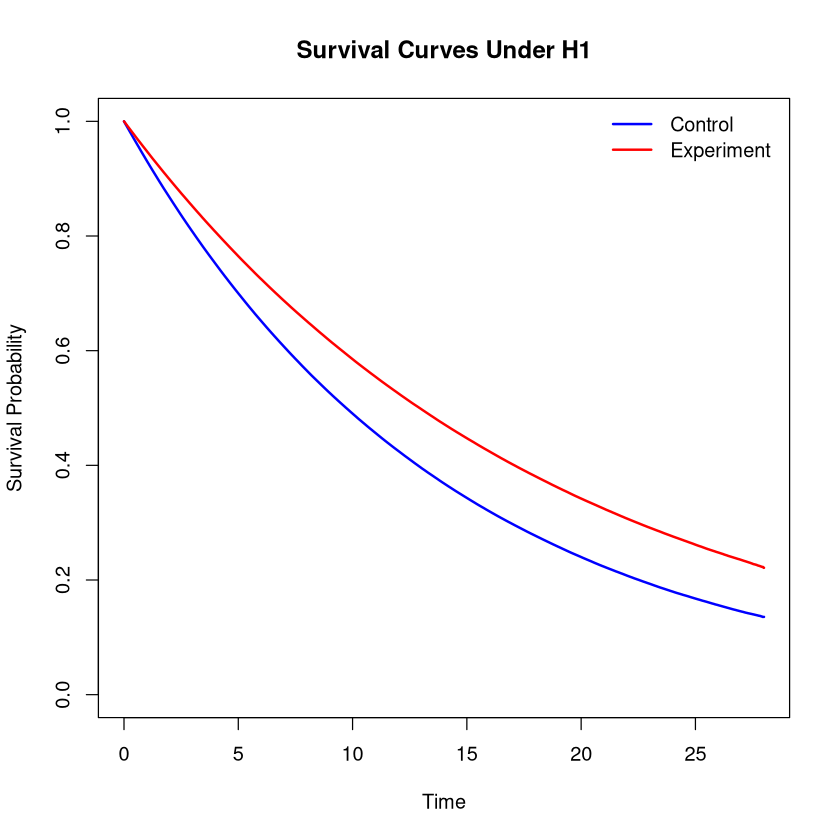

In [ ]:
lambda_H0 <- log(2) / 9.7
HR <- 0.75
lambda_H1 <- lambda_H0 * HR
sim_size <- 10000
acc_time <- 15
cen_time <- 13
n <- 200
set.seed(2024)
alpha <- 0.05
tau <- 24

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = 0)[ , c(4,5,1)]    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time,arm = 1, interim = 0)[ , c(4,5,1)]  
pre_data <- rbind(data_C, data_E_H1)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", 
    ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), 
            col = c("blue", "red"), lwd = 2, bty = "n")
# Under H1
log_rank_2 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
simple_rmst_2 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'two_sided')
log_rank_1 <- log_rank_sim(data_C = data_C, data_E = data_E_H1, sim_size = sim_size,
                            n = n, alpha = 0.05 ,sided = 'greater')
simple_rmst_1 <- RMST_sim_test(data_C = data_C, data_E = data_E_H1, sim_size = sim_size, tau = tau,
                            n = n, alpha = 0.05 ,sided = 'greater')                          
cat( 'The simulated power of two-sided(alpha = 0.05) log rank test is:', log_rank_2$rejection,'\n')
cat('The simulated power of two-sided(alpha = 0.05) simple rmst test is:', simple_rmst_2$test_result$rejection,'\n')
cat('************* two sided test in Eaton 2020 ************* ','\n')
cat( 'The simulated power of one-sided(alpha = 0.05) log rank test is:', log_rank_1$rejection,'\n')
cat('The simulated power of one-sided(alpha = 0.05) simple rmst test is:', simple_rmst_1$test_result$rejection)
            

----
# Real Example of Optimal Design
Atezolizumab versus docetaxel for patients with previously treated non-small-cell lung cancer (POPLAR): a multicentre, open-label, phase 2 randomised controlled trial
### The trial was designed with overall survival (OS) as the primary end point.  

Recruit period: 8 months
Experiment arm 144, control arm 143
Treatment start with the accrual   
Median follow-up 13 months 
HR = 0.73  
Experiment mOS = 12.6 months
Control mOS = 9.7 months 

### <span style="color:yellow"> Hypothesis: exponential proportional hazard
$$
H_0: \lambda_E = \lambda_C = log(2)/9.7 \\
H_1: \lambda_E = log(2)/12.6,\ \lambda_C = log(2)/9.7
$$

In [ ]:
set.seed(2024)
result <- data.frame()
lambda_H0 <- log(2) / 9.7
HR <- 0.73
lambda_H1 <- lambda_H0 * HR
sim_size <- 5000
acc_time <- 8
cen_time <- 13
alpha <- 0.05
power <- 0.8
tau_f <- 20

sel_col <- c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')

for (N in seq(from = 350, to = 374, 4))
{
    n <- ceiling(N / 2) 
    our_lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', 
                alpha = alpha, power = power, method = 'logrank') 

    sim_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', tau = tau_f,
            alpha = alpha, power = power, method = 'Simple')    

    our_rmst <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
            int_step = 8, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', tau = tau_f,
            alpha = alpha, power = power, method = 'Complex') 
        
    res <- rbind(our_lr_opt[, sel_col], sim_rmst[, sel_col], our_rmst[, sel_col])
    res$N <- N
    res$Method <- c('log_rank', 'simple_rmst', 'our_rmst')
    result <- rbind(result, res)
    saveRDS(result, "tem_result_ph.rds")
}
result

In [9]:
a <- 1

### If applying late difference piecewise exponential to fit the data
### Assume $HR_1 = 1$, control group follows exp dist and experiment group follows piecewise exp

In [16]:
# Solve HR2 according to the median OS of experiment group, 12.6
CT <- 3
lambda_c <- log(2) / 9.7
lambda_e1 <- lambda_c  # hazard before 4 months

# Survival function of piecewise exp
S1 <- function(t) exp(-lambda_e1 * t)
S2 <- function(t, lambda_e2) exp(-lambda_e2 * (t - CT))

# Overall survival function for the experimental group
S_overall <- function(t, lambda_e2) {
  if (t <= CT) {
    S1(t)
  } else {
    S1(CT) * S2(t, lambda_e2)
  }
}

# Find the lambda_experimental_after that gives a median OS of 12.6 months
median_target <- 12.6

# Function to find the root (when S_overall equals 0.5 at the median OS)
find_lambda_after <- function(lambda_e2) {
  S_overall(median_target, lambda_e2) - 0.5
}

# Use uniroot to solve for lambda_experimental_after
lambda_e2 <- uniroot(find_lambda_after, c(0.001, 0.1))$root
lambda_e2
lambda_e2/lambda_H0

[1] 0.04986097

[1] 0.6977614

-----